# 1. Libraries

In [25]:
#libraries
import pandas as pd
import matplotlib.pyplot as plt

#numpy
import numpy as np
from numpy import diff

#tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard

#sklearn
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

#scipy
from scipy import stats
from scipy.signal import find_peaks
from scipy import signal

#other 
from yahoo_fin import stock_info as si
from collections import deque
import time
import os
import random

#plotly
import plotly.graph_objects as go
import plotly.express as px



# 2. Data engineering

In [26]:
#import data
data = pd.read_csv('EURUSD.csv', header= None)

## 2.1. Data Cleaning

En una etapa se preparan los datos para su posterior uso en la red neural. (1) La información sobrante se borra del DataFrame y se corrigen los Nan. (2) Los datos se normalizan para facilitar su posterior tratamiento. Y (3) Las fechas se agrupan por días para facilitar su conteo y, posteriormente, su visualización.

In [27]:
def data_clean(df, time_interval):
    #create  some names
    df.rename(columns={0:'forex', 
                   1: 'ticker', 
                   2:'date',
                   3:'open', 
                   4:'high',
                   5:'low', 
                   6:'close', 
                   7:'interval'}, inplace=True)
    #delete nonsense columns
    x = np.arange(8,34,1)
    df = df.drop(df.columns[x.tolist()], axis=1)
    del df['forex']
    del df['ticker']
    
    #take 1 minute interval
    df = df.loc[df['interval'] == time_interval]
    df = df.reset_index()
    return df

In [28]:
#data_1_minute has all the inforamtion for 1 minute
data_1_minute = data_clean(df = data, time_interval = 1)

In [29]:
def normalize_data(df):
    #scale the data
    # Let's say X_train is your input dataframe
    
    # call MinMaxScaler object
    min_max_scaler = MinMaxScaler()
    # feed in a numpy array
    close_var = min_max_scaler.fit_transform(np.array(df['close']).reshape(-1, 1) )
    open_var = min_max_scaler.fit_transform(np.array(df['open']).reshape(-1, 1) )
    high_var = min_max_scaler.fit_transform(np.array(df['high']).reshape(-1, 1) )
    low_var = min_max_scaler.fit_transform(np.array(df['low']).reshape(-1, 1) )

    # wrap it up if you need a dataframe
    close_var = pd.DataFrame(close_var)
    open_var = pd.DataFrame(open_var)
    high_var = pd.DataFrame(high_var)
    low_var = pd.DataFrame(low_var)

    #drop the titles
    df.drop(labels=['close','open', 'high', 'low'], axis="columns", inplace=True)

    #rebuild the matrix as dataframe
    df['close'] = close_var[0]
    df['open'] = open_var[0]
    df['high'] = high_var[0]
    df['low'] = low_var[0]
    
    return df

In [30]:
#df has all the information 
df = normalize_data(data_1_minute)

In [31]:
#how many days
df['date'] = pd.to_datetime(df['date'])
dataframe_day_intervals = df.groupby(by=df['date'].dt.date).count()['interval'].values
len(dataframe_day_intervals)

401

In [32]:
#data.head(5)
#data_1_minute.head(5)
df.head(5)

,index,date,interval,close,open,high,low
0,0,2018-01-02 00:01:00,1,0.713331,0.716239,0.715591,0.714226
1,1,2018-01-02 00:02:00,1,0.713801,0.713525,0.713137,0.714435
2,2,2018-01-02 00:03:00,1,0.714375,0.713838,0.714181,0.714748
3,4,2018-01-02 00:04:00,1,0.714427,0.714360,0.713816,0.715269
4,5,2018-01-02 00:05:00,1,0.715054,0.714465,0.714390,0.715009


In [33]:
#lenght of the set reduced, data_1–minute must match with df
print("Lenght of : data {0}".format(str(len(data))))
print("Lenght of : data_1_minute {0}".format(str(len(data_1_minute))))
print("Lenght of : df {0}".format(str(len(df))))

Lenght of : data 855951
Lenght of : data_1_minute 569935
Lenght of : df 569935


## 2.2. Functions

En lo que sigue se implementan las funciones para la el modelo neural.

### 2.2.1

In [34]:
def day_data(dataframe, column_name):
    #group dates to find the  batches
    dataframe['date'] = pd.to_datetime(dataframe['date'])
    
    #df_day_intervals define the quantity of data grouped by day
    dataframe_day_intervals = dataframe.groupby(by=dataframe['date'].dt.date).count()['interval'].values
    quantity_of_days = len(dataframe_day_intervals)
    
    #print(df_day_intervals)
    #print(df.groupby(by=df['date'].dt.date).count())
    
    #generate the batch list by days, retrieve Dataframe by day
    dataframe_day_intervals_array = [0]
    counter = 0
    for i in range(len(dataframe_day_intervals)):
        #counter sum over  each day and save in this variable
        counter += dataframe_day_intervals[i]
        #append the sum
        dataframe_day_intervals_array.append(counter)  
        
    #print(df_day_intervals_array, len(df_day_intervals_array))
    
    #group data by each interval as a dataframe
    dataframe_day_dataframe = []
    counter = 0
    for i in range(len(dataframe_day_intervals_array)-1):
        #make the delta time with intervals [counter-1,counter+1]
        counter += 1
        s_1 = dataframe.iloc[dataframe_day_intervals_array[counter-1]:dataframe_day_intervals_array[counter]]
        dataframe_day_dataframe.append(s_1)
        
    #generate the arrays with values of given column   
    x_s, y_s = [],[]
    for i in range(len(dataframe_day_dataframe)):
        x_s.append(dataframe_day_dataframe[i][column_name].index.values)
        y_s.append(dataframe_day_dataframe[i][column_name].values)
        
    return x_s, y_s, quantity_of_days

### 2.2.2. Fourier Filter

El filtro de fourier permite suavizar el ruido de los datos. De está forma, se hace mucho más clara la tendencia de "largo aliento" que subyace al ruido de los registros.

In [35]:
#fourier filter def
def fourier_filter(y, value):
    """input:(int, array-like , float)
    
    int: The order of the filter.
    
    list:array_like = The critical frequency or frequencies. For lowpass and highpass filters,
    Wn is a scalar; for bandpass and bandstop filters, Wn is a length-2 sequence.
    
    value: The sampling frequency of the digital system
    
    
    return: ndarray y values of fourier filter
    
    description: Butterworth digital and analog filter design.
    Design an Nth-order digital or analog Butterworth filter and return the filter coefficients.
    """
    
    b, a = signal.butter(3, value)
    y_p = signal.filtfilt(b, a, y)
    return y_p

### 2.2.3. Poly Fit

Se crea una función para encontrar la función de mejor ajuste. La implementación permite manipular el grado del polinomio de dicha función.

In [36]:
#linear eqution 
def linear_equations(x, y, degree):
    """input: (list, list, degree)
    1st entry: x-axis
    2nd entry: y-axis
    3rd entry: degree of the polynomil you want to fit
    
    return: (float, float)
    1st outcome: p(x_s) = intercept
    2nd outcome: z = slope
    
    description: polyfit function for any polinomial
    
    """
    
    #generate the slopes and intersections lienarly  
    z = np.polyfit(x, y, degree)
    p = np.poly1d(z)    
    return p(x), z

In [37]:
len(x_tot)
x_tot[]

SyntaxError: invalid syntax (<ipython-input-37-28ab8e4c2eb1>, line 2)

In [38]:
#dont use this function, flatten array of all the data 
#get 1 single array with all values
def single_array(nested_list):
    a = []
    for i in range(days):
        for j in range(len(nested_list[i])):
            a.append(nested_list[i][j])
        
    return a

### 2.2.4. Derivate Function

La función calcula la derivada del 1er parámentro del entrada con respeto al segundo parámetro de entrada.

In [39]:
#get derivative
def derivative(y_values, x_values):
    """input: list,  y values
    
    return: dy 
    
    description: differencial dx = 0.1
    
    """
    dx = 0.1
    dy = diff(y_values)/diff(x_values)
    #return derivative
    return dy

In [40]:
#find derivatives =0
def derivative_0(dy):
    """input: list, dy values,  derivates  
    
    return: positions where dy/dx =0 
    
    description: takes -abs(dy), and find peaks of this plot
    
    """
    #find peaks
    peaks, _ = find_peaks(-np.abs(dy))
    #return index of the peaks
    return peaks

In [41]:
# able or unable zoom in plots
def zoom(s):
    if s == True:
        # unable zoom in plot
        %matplotlib inline
        import mpld3
        mpld3.enable_notebook()
    elif s == False :
        # disable zoom in plot
        %matplotlib auto

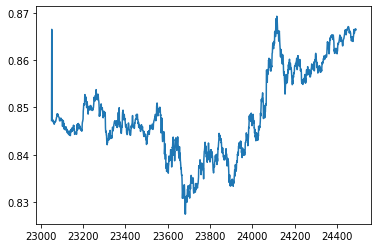

In [42]:
#Example
#get all the daata by bacthes of 1 day
zoom(True)
day_we_want_to_see =  15

#retrieve information
x = day_data(df,'close')[0][day_we_want_to_see]
y = day_data(df,'close')[1][day_we_want_to_see]

#days have how many days of the array
days = day_data(df,'close')[2]

#plot the day
plt.plot(x,y)

plt.show()

In [23]:
#get all data by batches of 1 day
# 8:00 minutes running
x_tot = []
y_tot = []
#for i in range(len(days)):
for i in range(days):
    x_tot.append(day_data(df,'close')[0][i])
    y_tot.append(day_data(df,'close')[1][i])

In [24]:
#kk gives  array of lenght of day by index
kk=[]
for i in range(days):
    kk.append(len(y_tot[i]))
    
#print(len(kk),len(x_tot),kk)

In [25]:
#find the group (day) that contains 2 values
for i in range(len(x_tot)):
    if (len(x_tot[i])) ==2 :
        print(i)

260


In [26]:
#erase position 260
del x_tot[260]
del y_tot[260]

In [27]:
#number of days
days = len(x_tot)

In [244]:
#get slopes of all the data usnig a fourier filter
slopes_tot = []
z = []
deg =1
f = 0.1
for i in range(days):
    slopes_tot.append(linear_equations(x_tot[i], fourier_filter(y_tot[i], f),deg)[0])
    z.append(linear_equations(x_tot[i], fourier_filter(y_tot[i], f),deg)[1])

In [245]:
#get slopes of 26 firts data  of a day by using the fourier filter of this data and a 2nd degree 
#polinomial fit aplied to this filter
slopes_m = []
z_m = []
e = 26
deg =2
f = 0.9
for i in range(days):
    slopes_m.append(linear_equations(x_tot[i][:e], fourier_filter(y_tot[i][0:e], f),deg)[0])
    z_m.append(linear_equations(x_tot[i][:e],fourier_filter(y_tot[i][0:e], f),deg)[1])

In [246]:
#data of the slopes that match, 1 if positive 0 negative slpopes
t = []
tt = []
for i in range(len(z)):
    if z[i][0] > 0 :
        t.append(1)
    else: 
        t.append(0)
        
for i in range(len(z_m)):
    if z_m[i][0] > 0 :
        tt.append(1)
    else: 
        tt.append(0)
        
s =0
dont_match =[]
match =[]
for i in range(len(t)):
    if t[i] == tt[i]:
        s+=1
        match.append(i)
    else:
        dont_match.append(i)
print(s)

351


In [247]:
print("Total slopes:   {0}".format(len(slopes_tot)))
print("26 min slopes:  {0}".format(s))
print("Percentage that match: {:.2f}%".format((s*100)/len(slopes_tot)))

Total slopes:   400
26 min slopes:  351
Percentage that match: 87.75%


In [248]:
day = 1
initial = 0

In [323]:
#get fourier  of all data = fourier_tot
#fourier of 26 fisrt minutes of the day 
fourier_tot = []
fourier_26_min =[]
for i in range(days):
    fourier_tot.append(fourier_filter(y_tot[i], 0.09))
    fourier_26_min.append(fourier_filter(y_tot[i][0:e], 0.001))

In [324]:
#get an entire list 1d of all slopes 
z_l =[] 
z_l_t = []
for i in range(len(z)):
    z_l.append(z[i][0])
    z_l_t.append(z_m[i][0])

In [325]:
#scale the data of the slopes
min_max_scaler = MinMaxScaler()
z_list = min_max_scaler.fit_transform(np.array(z_l).reshape(-1, 1) )
z_list_t = min_max_scaler.fit_transform(np.array(z_l_t).reshape(-1, 1) )
#x_list = np.array(np.arange(0,len(z_list), 1)).reshape(-1,1)

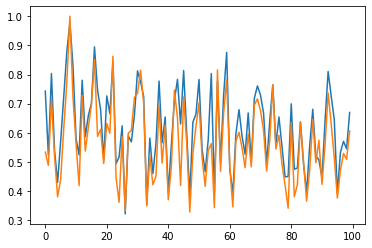

In [326]:
zoom(True)
plt.plot(z_list[0:100])
plt.plot(z_list_t[0:100])

In [18]:
day =168
x_g = x_tot[day]
y_g = fourier_tot[day]
zeros = derivative_0(derivative(y_g, x_g))

NameError: name 'x_tot' is not defined

In [328]:
print("Standard deviation of all day data: {:.5f}".format(np.std(y_tot[day])))
print("Standard deviation of 15 first data: {:.5f}".format(np.std(y_tot[day][0:15])))

Standard deviation of all day data: 0.01683
Standard deviation of 15 first data: 0.01063


In [329]:
outliers_positive = []
outliers_negative = []
for i in range(len(y_tot[day])):
    if (y_tot[day][i] > fourier_tot[day][i]+ np.std(y_tot[day][0:15]))or (y_tot[day][i] == fourier_tot[day][i]+ np.std(y_tot[day][0:15])) ==True:
        outliers_positive.append(i)
    elif (y_tot[day][i] < fourier_tot[day][i]- np.std(y_tot[day][0:15]))or (y_tot[day][i] == fourier_tot[day][i]- np.std(y_tot[day][0:15])) ==True:
        outliers_negative.append(i)
    

In [330]:
print(len(outliers_negative), len(outliers_positive))

0 1


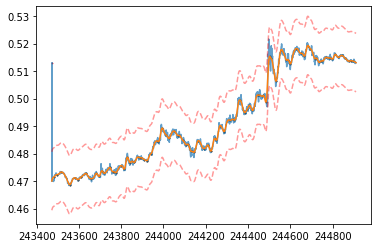

In [331]:
zoom(True)
plt.plot(x_tot[day], y_tot[day], alpha =0.7)
plt.plot(x_g, y_g)

plt.scatter(x_g[outliers_positive], y_tot[day][outliers_positive], s = 0.5, color ='red')
plt.scatter(x_g[outliers_negative], y_tot[day][outliers_negative], s = 0.5, color ='red')
plt.scatter(x_g[zeros], y_g[zeros],s = 1, color ="black")



plt.plot(x_tot[day], fourier_tot[day]+ np.std(y_tot[day][0:15]), 'r--', alpha = 0.4)
plt.plot(x_tot[day], fourier_tot[day]- np.std(y_tot[day][0:15]), 'r--', alpha = 0.4)

# Here starts LSTM

In [132]:
X = single_array(x_tot)
Y = single_array(y_tot)


In [150]:
dataset = pandas.read_csv('airline-passengers.csv', usecols=[1], engine='python')


In [161]:
dataset

pandas.core.frame.DataFrame

In [152]:
zoom(False)
plt.plot(dataset)
plt.show()

Using matplotlib backend: Qt5Agg


In [154]:
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

In [156]:
plt.plot(dataset)

In [105]:
# split into train and test sets
train_size = int(len(dataset) * 0.8)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

455946 113987


In [108]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

In [109]:
# reshape into X=t and Y=t+1
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [111]:
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [118]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

model.fit(trainX, trainY,
          epochs=15, 
          batch_size=1200, 
          verbose=1)

Epoch 1/5
380/380 [==============================] - 5s 13ms/step - loss: 69295611904.0000
Epoch 2/5
380/380 [==============================] - 5s 14ms/step - loss: 69295046656.0000
Epoch 3/5
380/380 [==============================] - 5s 14ms/step - loss: 69294456832.0000
Epoch 4/5
380/380 [==============================] - 5s 14ms/step - loss: 69293809664.0000
Epoch 5/5
380/380 [==============================] - 5s 13ms/step - loss: 69292687360.0000


In [124]:
trainPredict = model.predict(trainX)

array([[1.9842863],
       [3.3110087],
       [4.4772363],
       ...,
       [7.056985 ],
       [7.056985 ],
       [7.056985 ]], dtype=float32)

In [123]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

ValueError: non-broadcastable output operand with shape (455944,1) doesn't match the broadcast shape (455944,2)

In [ ]:
# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions

zoom(False)
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()